# SAG mill prediction

The goal of the project is to devise and implement a prototype data-driven
prediction model of a Semi-autogenous (SAG) Mill.

In this notebook, we want to create a model with multiple inputs to predict performance variables 5 minutes in advance.

We use a **Multi Variate- Multi Steps Long Short Term Model (LSTM)**.

## Multi Variate/ Multi Steps LSTM

Long-Short-Term Memory (LSTM) is the next generation of Recurrent Neural Network (RNN) used in deep learning for its optimized architecture to easily capture the pattern in sequential data. 

The benefit of this type of network is that it can learn and remember over long sequences and does not rely on pre-specified window lagged observation as input.

## Importing libraries

In [1]:
# General
import pandas as pd
import numpy as np
from scipy import interpolate
import itertools

# Plotting
import matplotlib.pyplot as plt
%matplotlib inline
from matplotlib.pylab import rcParams
rcParams['figure.figsize'] = 8, 6
plt.style.use('seaborn')

# Warnings
import warnings
warnings.filterwarnings('ignore')

In [2]:
# Statistical models
import statsmodels.api as sm
from statsmodels.tsa.stattools import adfuller

In [3]:
# LSTM
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error

import keras.callbacks
from keras.models import Sequential
from keras.layers import Dense,Activation,Flatten,Dropout
from tensorflow.keras.layers import LSTM

## Loading data

In [4]:
# Load dataset
df_eda = pd.read_csv('input/sag_data_EDA.csv', header=0, index_col=0)
values = df_eda.values

In [5]:
df_eda.head(3)

,Bearing Pressure (kPa),Power Draw (MW),Speed (RPM),Dilution Flow Rate (m3/h),Conveyor Belt Feed Rate (t/h),Conveyor Belt PSD Fines (%)
Time,,,,,,
2015-12-21 00:00:00,5364.649789,12.762004,8.073871,1073.169397,2940.881221,40.390537
2015-12-21 00:01:00,5343.775163,12.491533,7.889129,1057.823776,3042.468414,44.751640
2015-12-21 00:02:00,5350.858199,12.290888,7.970280,1036.836364,2959.495635,42.130604


In [6]:
df_eda.shape

(28801, 6)

In [7]:
col = df_eda.columns
col

Index(['Bearing Pressure (kPa)', 'Power Draw (MW)', 'Speed (RPM)',
       'Dilution Flow Rate (m3/h)', 'Conveyor Belt Feed Rate (t/h)',
       'Conveyor Belt PSD Fines (%)'],
      dtype='object')

<!-- Rearrange the dataframe with Bearing Pressure and Power Draw as last columns -->

## Building the LSTM Forecast Model

We define a function to convert times series into supervised learning problem.

In [8]:
# From: machinelearningmastery.com/blog/

def time_series_to_supervised(data, n_lag = 1, n_fut = 1, selLag = None, sel_fut = None, dropnan = True):
    """
    Converts a time series to a supervised learning data set by adding time-shifted prior and future period
    data as input or output (i.e., target result) columns for each period
    
    - data:  a series of periodic attributes
    - n_lag: number of prior periods to lag as input (X)
    - n_fut: number of future periods to add as target output (y)
    - selLag:  only copy these specific PRIOR period attributes
    - selFut:  only copy these specific FUTURE period attributes
    - dropnan: True= drop rows with NaN values
    """
    
    n_vars = 1 if type(data) is list else data.shape[1]
    df = pd.DataFrame(data)
    origNames = df.columns
    
    cols, names = list(), list()
    
    # Include all current period attributes
    cols.append(df.shift(0))
    names += [('%s' % origNames[j]) for j in range(n_vars)]
 
    # Lag any past period attributes (t-n_lag,...,t-1)
    n_lag = max(0, n_lag)  # force valid number of lag periods
    for i in range(n_lag, 0, -1):
        suffix= '(t-%d)' % i
        if (None == selLag):   # copy all attributes from PRIOR periods?
            cols.append(df.shift(i))
            names += [('%s%s' % (origNames[j], suffix)) for j in range(n_vars)]
        else:
            for var in (selLag):
                cols.append(df[var].shift(i))
                names += [('%s%s' % (var, suffix))]
 
    # Include future period attributes (t+1,...,t+n_fut)
    n_fut = max(n_fut, 0)  # force valid number of future periods to shift back
    for i in range(1, n_fut + 1):
        suffix= '(t+%d)' % i
        if (None == sel_fut):  # copy all attributes from future periods?
            cols.append(df.shift(-i))
            names += [('%s%s' % (origNames[j], suffix)) for j in range(n_vars)]
        else:  # copy only selected future attributes
            for var in (sel_fut):
                cols.append(df[var].shift(-i))
                names += [('%s%s' % (var, suffix))]
                
    # Combine everything
    agg = pd.concat(cols, axis=1)
    agg.columns = names
    
    # drop rows with NaN values introduced by lagging
    if dropnan:
        agg.dropna(inplace=True)
    return agg

Problem Framing:

    Multivariate
    - Bearing Pressure (kPa), Power Draw (MW), Speed (RPM), Dilution Flow Rate (m3/h), Conveyor Belt Feed Rate (t/h), Conveyor Belt PSD Fines (%)
    
    Multivariate, multistep output 
    - Bearing Pressure (kPa), Power Draw (MW)
    
    Predict the next 5 minutes Bearing Pressure/ Power Draw using the previous 20 minutess

We define the variables of the problem.

In [9]:
# Input
n_features_in = 6
n_features_out = 1

# Output
n_lags_in = 20
n_lags_out = 5

Rearrange the data to a **supervised learning problem** using the time_series_to_supervised function.

In [11]:
# Target columns specified in the baseline
target_cols = ['Bearing Pressure (kPa)', 'Power Draw (MW)']

In [12]:
# Bearing Pressure (kPa)
prx = time_series_to_supervised(df_eda, n_lag = n_lags_in, n_fut = n_lags_out, sel_fut = [target_cols[0]])

# Power Draw (MW)
# pwr = time_series_to_supervised(df_eda, n_lag = n_lags_in, n_fut = n_lags_out, sel_fut = [target_cols[1]])

In [13]:
prx.head(1)

,Bearing Pressure (kPa),Power Draw (MW),Speed (RPM),Dilution Flow Rate (m3/h),Conveyor Belt Feed Rate (t/h),Conveyor Belt PSD Fines (%),Bearing Pressure (kPa)(t-20),Power Draw (MW)(t-20),Speed (RPM)(t-20),Dilution Flow Rate (m3/h)(t-20),...,Power Draw (MW)(t-1),Speed (RPM)(t-1),Dilution Flow Rate (m3/h)(t-1),Conveyor Belt Feed Rate (t/h)(t-1),Conveyor Belt PSD Fines (%)(t-1),Bearing Pressure (kPa)(t+1),Bearing Pressure (kPa)(t+2),Bearing Pressure (kPa)(t+3),Bearing Pressure (kPa)(t+4),Bearing Pressure (kPa)(t+5)
Time,,,,,,,,,,,,,,,,,,,,,
2015-12-21 00:20:00,5377.294125,12.235626,7.867987,1071.660896,2955.094739,46.442123,5364.649789,12.762004,8.073871,1073.169397,...,12.314965,7.861659,1075.353614,3047.464287,42.888683,5425.893849,5427.745119,5397.426528,5419.989363,5399.19581


In [14]:
prx.shape

(28776, 131)

In [15]:
# pwr.head(1)

In [16]:
# pwr.shape

<font color='red'>
Note: For this exercise, we will only make predictions on the 'Bearing Pressure (kPa)' column. 
</font>

We end up with 20x6 + 5x2 + 6 = 131 columns. That splits as:

- 20 x 6 = n_in x n_features (in)
- 5 x 2 = n_out x n_features (out)
- 1 x 6 = n_features a time t

In [17]:
def df_columns(df):
    for i in prx.columns:
        print(i)

In [18]:
# prx_col = df_columns(prx)
# prx_col

In [19]:
# pwr_col = df_columns(pwr)
# pwr_col

In [20]:
n_obs_in = (n_features_in * n_lags_in)
n_obs_out = (n_features_out * n_lags_out)
print ('Number of observations in:',n_obs_in)
print ('Number of predictions out:', n_obs_out)

# Creating X, y from data_test
X = prx.values[:, :n_obs_in]
y = prx.values[:, -n_obs_out:]
print ('\nShape of X:',X.shape)
print ('Shape of y:', y.shape)

Number of observations in: 120
Number of predictions out: 5

Shape of X: (28776, 120)
Shape of y: (28776, 5)


In [21]:
# Normalize data with a scaler
X_scaler = MinMaxScaler(feature_range=(0,1)).fit(X)
y_scaler = MinMaxScaler(feature_range=(0,1)).fit(y)

### Split Dataset

We split the prepared dataset into train and test sets.

- Total = 20 days
- Train = 70% tot (14 days)
- Test = 30% tot (6 days)

In [22]:
# Train/test set
n_tot = df_eda.shape[0]
n_train = int(0.7 * df_eda.shape[0])
n_test = n_tot - n_train

print(f'Training minutes: {str(n_train)}')
print(f'Test minutes: {str(n_test)}')
print(f'Total minutes: {str(n_tot)}')

Training minutes: 20160
Test minutes: 8641
Total minutes: 28801


In [23]:
# Split X, y into train/test
X_train, y_train = X[:n_train, :], y[:n_train, :]
X_test, y_test = X[n_train:, :], y[n_train:, :]

print('Shape of splits:')
print(X_train.shape, y_train.shape, X_test.shape, y_test.shape)

Shape of splits:
(20160, 120) (20160, 5) (8616, 120) (8616, 5)


In [24]:
# Scale the data with Scaler
X_train, y_train = X_scaler.transform(X_train), y_scaler.transform(y_train)
X_test, y_test = X_scaler.transform(X_test), y_scaler.transform(y_test)

In [25]:
# Reshape input to be 3D [samples, timesteps, features] for LSTM
X_train = X_train.reshape((X_train.shape[0], n_lags_in, n_features_in))
X_test = X_test.reshape((X_test.shape[0], n_lags_in, n_features_in))

print('Re-shaped for LSTM:')
print(X_train.shape, y_train.shape, X_test.shape, y_test.shape)

Re-shaped for LSTM:
(20160, 20, 6) (20160, 5) (8616, 20, 6) (8616, 5)


In [26]:
# Visualizing the input and output being sent to the LSTM model
# Based on last 20 minutes we are learning the next 5 minutes
for inp, out in zip(X_train[0:1], y_train[0:1]):
    print('--- Input ---')
    print(inp)
    print('\n--- Output ---')
    print(out)

--- Input ---
[[0.6895872  0.8185136  0.20558113 0.64470029 0.83861287 0.55936956]
 [0.66847025 0.85366288 0.21096063 0.64560779 0.83457928 0.48648157]
 [0.63360813 0.83560199 0.20613354 0.63637602 0.86340825 0.53900863]
 [0.6454373  0.82220375 0.20825392 0.62375021 0.83986178 0.5074397 ]
 [0.66260647 0.85528319 0.21657374 0.63464399 0.84975404 0.46269234]
 [0.55187413 0.87024098 0.21638834 0.65250819 0.83756758 0.54224524]
 [0.57919572 0.85829236 0.2108614  0.64905721 0.84999961 0.49137255]
 [0.61373797 0.84568887 0.20857962 0.62585719 0.8455655  0.47545735]
 [0.61788996 0.82704206 0.20576647 0.63268383 0.8537265  0.58050872]
 [0.60247193 0.8248652  0.2083284  0.63940192 0.83905431 0.53571371]
 [0.57607991 0.85533239 0.21004716 0.62114954 0.85979314 0.44497298]
 [0.64677251 0.83817065 0.2087591  0.62023288 0.84092975 0.50190519]
 [0.59434296 0.83483188 0.20885052 0.63402412 0.85421556 0.46628503]
 [0.64403815 0.87041786 0.21455387 0.63548524 0.85104802 0.50743111]
 [0.6146136  0.86099

### Define and fit the Model

We define the LSTM with 50 neurons in the first hidden layer and 5 neurons in the output layer (5 future values). The input shape is 20 time step with 6 features.

We will use the Mean Absolute Error (MAE) loss function and the efficient Adam version of stochastic gradient descent.

In [27]:
# Design network
model = Sequential()

model.add(LSTM(50, activation = 'relu', return_sequences = True, input_shape = (n_lags_in, n_features_in)))
model.add(LSTM(50, activation = 'relu'))
model.add(Dense(n_lags_out))

model.compile(optimizer ='adam', loss = 'mae')

In [28]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 20, 50)            11400     
_________________________________________________________________
lstm_1 (LSTM)                (None, 50)                20200     
_________________________________________________________________
dense (Dense)                (None, 5)                 255       
Total params: 31,855
Trainable params: 31,855
Non-trainable params: 0
_________________________________________________________________


We define a function that finds the beat batch size for the model fit.

In [29]:
def computeHCF(x, y):
    
    '''
    Function that finds the highest common factor of both the length of train_X/test_X.
    '''
    if x > y:
        smaller = y
    else:
        smaller = x
    for i in range(1, smaller+1):
        if((x % i == 0) and (y % i == 0)):
            hcf = i

    return hcf

batch_size = computeHCF(X_train.shape[0], y_test.shape[0])
batch_size

24

In [30]:
import time
# Measuring the time taken by the model to train
start = time.time()

# Fitting the RNN to the Training Set
history = model.fit(X_train, y_train, 
                    epochs = 50, 
                    batch_size = batch_size, 
                    validation_data = (X_test, y_test), 
                    verbose = 1, 
                    shuffle = False)

end = time.time()
print("Total Time: ", round((end - start)/60), 'Minutes')

Epoch 1/50
840/840 [==============================] - 7s 8ms/step - loss: 0.0721 - val_loss: 0.0792
Epoch 2/50
840/840 [==============================] - 7s 8ms/step - loss: 0.0665 - val_loss: 0.0929
Epoch 3/50
840/840 [==============================] - 6s 8ms/step - loss: 0.0704 - val_loss: 0.0969
Epoch 4/50
840/840 [==============================] - 6s 7ms/step - loss: 0.0721 - val_loss: 0.0965
Epoch 5/50
840/840 [==============================] - 6s 8ms/step - loss: 0.0725 - val_loss: 0.0937
Epoch 6/50
840/840 [==============================] - 6s 7ms/step - loss: 0.0704 - val_loss: 0.0908
Epoch 7/50
840/840 [==============================] - 7s 8ms/step - loss: 0.0648 - val_loss: 0.0897
Epoch 8/50
840/840 [==============================] - 7s 8ms/step - loss: 0.0635 - val_loss: 0.0847
Epoch 9/50
840/840 [==============================] - 7s 8ms/step - loss: 0.0566 - val_loss: 0.0789
Epoch 10/50
840/840 [==============================] - 6s 8ms/step - loss: 0.0520 - val_loss: 0.0698

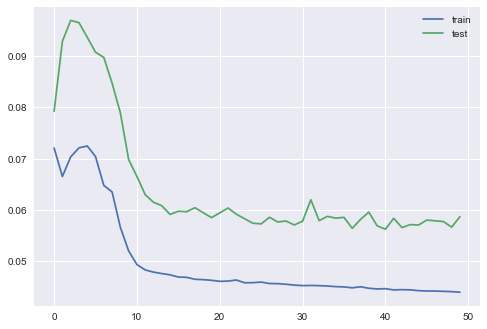

In [31]:
# Plot history
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')

plt.legend()
plt.show()

### Comments

The performance of the model is poor. The plot indicates that there is overfitting (our model doesn't generalize well from our training data).

To overcome this issue, we could do a grid search to choose the best parameters for the model. Since this issue is not very relevant to complete this exercise, we decide not to consider it.

### Evaluate the Model

We'll first try and make a single prediction from the first X_test value.


In [32]:
# Check the shape of X_test[0]
X_test[0].shape

(20, 6)

In [33]:
# Reshape X_test[0] into 3D
x_input = X_test[0].reshape((1, n_lags_in, n_features_in))
print ('Input shape: ',x_input.shape)

Input shape:  (1, 20, 6)


In [34]:
# Prediction
yhat = model.predict(x_input)
yhat

array([[0.44925094, 0.45179182, 0.4515429 , 0.4515916 , 0.4549414 ]],
      dtype=float32)

In [35]:
print ('Output shape: ', yhat.shape)

Output shape:  (1, 5)


In [36]:
# Invert the scaling for yhat using the y_scaler from above
inv_yhat = y_scaler.inverse_transform(yhat)
inv_yhat

array([[5233.386 , 5234.9077, 5234.759 , 5234.7876, 5236.794 ]],
      dtype=float32)

In [37]:
# Check the shape of y_test[0]
print (y_test[0].shape)
y_test[0]

(5,)


array([0.4607577 , 0.43781094, 0.36426305, 0.40550191, 0.34409069])

In [38]:
# Reshape y_test
inv_y = y_test[0].reshape(1, y_test[0].shape[0])
inv_y.shape

(1, 5)

In [39]:
# Invert the scaling for y_test
inv_y = y_scaler.inverse_transform(inv_y)
inv_y

array([[5240.27635359, 5226.53637078, 5182.49760781, 5207.19047228,
        5170.41886497]])

In [40]:
# inv_yhat[0].shape

In [41]:
# inv_y[0].shape

In [42]:
# rmse = (mean_squared_error(inv_y, inv_yhat))**0.5

# print ('Root Mean Squared Error:', round(rmse,2))

Now, we predict the entire X_test in one go.

In [43]:
# Prediction
yhat_tot = model.predict(X_test)
yhat_tot.shape

(8616, 5)

In [44]:
# Invert scaling for yhat using y_scaler
inv_yhat_tot = y_scaler.inverse_transform(yhat_tot)

print ('Output shape:',inv_yhat_tot.shape)

Output shape: (8616, 5)


In [45]:
# inv_yhat_tot[0]

In [46]:
inv_pred_y = inv_yhat_tot[:,0]
inv_pred_y

array([5233.386 , 5240.3633, 5232.2183, ..., 5249.5933, 5231.079 ,
       5237.5806], dtype=float32)

In [47]:
# Invert the scaling for yhat using the y_scaler from above
inv_y_tot = y_scaler.inverse_transform(y_test)
inv_y_tot = inv_y_tot[: ,0]
inv_y_tot

array([5240.27635359, 5226.53637078, 5182.49760781, ..., 5205.51158586,
       5222.72087902, 5180.44723557])

In [48]:
inv_y_tot.shape

(8616,)

## Errors Statistics

In [49]:
rmse = (mean_squared_error(inv_y_tot, inv_pred_y))**0.5

print(f'Bearing Pressure (kPa) RMSE: {round(rmse,3)}')
# print(f'Power Draw (MW)  RMSE: {round(rmse,3)}')

Bearing Pressure (kPa) RMSE: 34.684


In [50]:
errors = inv_pred_y - inv_y_tot
prex_err = pd.Series(errors)

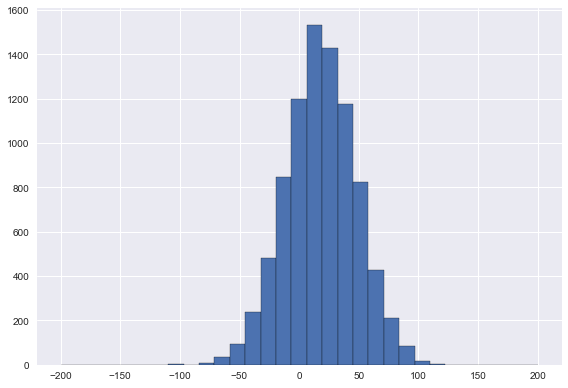

In [51]:
prex_err.hist(bins=31, range=(-200, 200), edgecolor="k")
plt.tight_layout()

## Result visualization

In [52]:
df = df_eda[df_eda.columns].tail(20)
df.reset_index(drop=True, inplace=True)

In [53]:
prex_df = pd.DataFrame(inv_yhat.T, columns=['Bearing Pressure (kPa)'])
prex_df

,Bearing Pressure (kPa)
0,5233.386230
1,5234.907715
2,5234.758789
3,5234.787598
4,5236.793945


In [54]:
fin_df = pd.concat([df, prex_df], axis=0)
fin_df.reset_index(drop=True, inplace=True)
fin_df

,Bearing Pressure (kPa),Power Draw (MW),Speed (RPM),Dilution Flow Rate (m3/h),Conveyor Belt Feed Rate (t/h),Conveyor Belt PSD Fines (%)
0,5226.687945,13.792963,8.605374,894.526064,2662.211719,38.448288
1,5194.255639,13.926023,8.622645,966.936009,2668.865003,38.210907
2,5217.482121,14.036532,8.721505,926.581224,2656.647339,37.343918
3,5220.366110,14.036866,8.714745,902.707493,2653.069154,39.782646
4,5178.873228,14.009403,8.707571,913.374372,2668.675722,42.357128
5,5246.019610,14.041437,8.636298,955.526074,2641.592963,41.161613
6,5202.400444,13.856403,8.620456,908.149349,2672.420547,44.644703
7,5231.977061,13.876529,8.609664,960.181175,2701.484842,33.692871
8,5191.135840,13.824024,8.616953,932.075269,2612.006607,45.834385
9,5222.697323,13.867555,8.615253,943.694711,2656.709100,32.163284


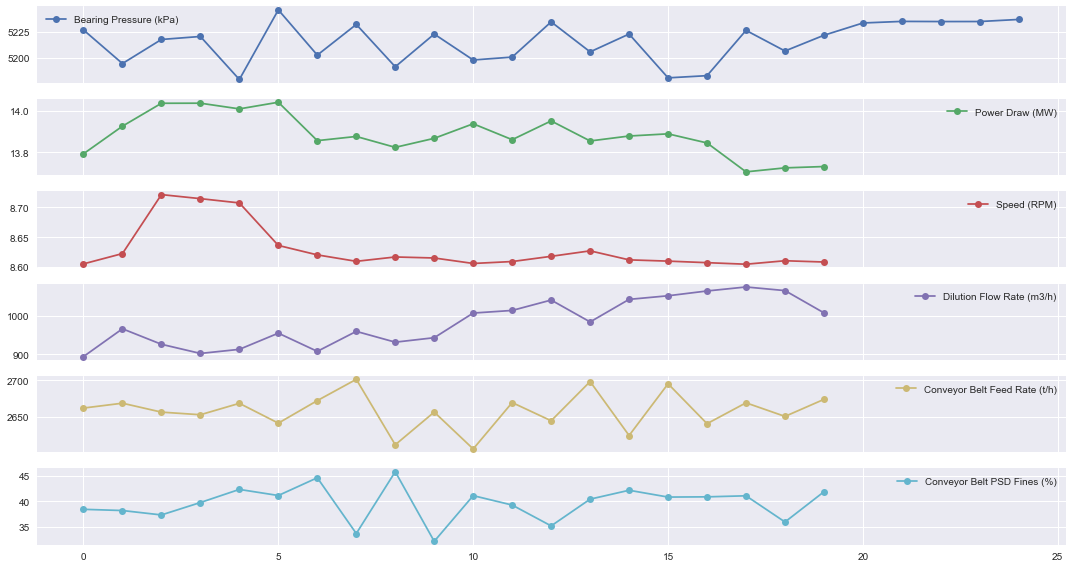

In [55]:
fin_df.plot(subplots=True, marker = 'o', figsize=(15, 8))

plt.tight_layout()
plt.show()

## Conclusions

- The error and prediction of the pressure setup using 20 minutes of history inputs confirm the indication given in the baseline.

- As said, the model prediction is poor due to an overfitting issue that we decide not to solve in this exercise.

- Unfortunately, we haven't been able to extract power data.

## References

- https://machinelearningmastery.com/

- https://medium.com/analytics-vidhya/multi-step-lstm-time-series-forecasting-bf82889ed173